### To view the notebook and map on nbviewer

## Data Preparation

### 1. Import libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import requests

!pip -q install geocoder
import geocoder

!pip -q install geopy
from geopy.geocoders import Nominatim

! pip install folium==0.5.0
import folium

import json
from pandas.io.json import json_normalize

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

print('Libraries imported')

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: 

### 2. Scrap webpage to get the list of London Tube stations in Zone 1

In [2]:
import urllib.request
from bs4 import BeautifulSoup

wiki = "https://en.wikipedia.org/wiki/List_of_stations_in_London_fare_zone_1"
page = urllib.request.urlopen(wiki)
soup = BeautifulSoup(page)

In [3]:
table = soup.find('table', {'class':'wikitable sortable'}).tbody
rows = table.find_all('tr')

columns = [i.text.replace('\n', '')
           for i in rows[0].find_all('th')]
df_Z1_list = pd.DataFrame(columns = columns)

for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    if len(tds) == 5:
        values = [tds[0].text.replace('\n', ''.replace('\xa0','')), tds[1].text, tds[2].text, tds[3].text, tds[4].text.replace('\n', ''.replace('\xa0',''))]
    else:
        values = [td.text.replace('\n', '').replace('\xa0','') for td in tds]
    df_Z1_list = df_Z1_list.append(pd.Series(values, index = columns), ignore_index = True)

df_Z1_list.head()

,Station,Local authority,Managed by,1981 to 1983[6],Notes
0,Aldgate,City of London,London Underground,City,
1,Aldgate East,Tower Hamlets,London Underground,City,
2,Angel,Islington,London Underground,City,
3,Baker Street,Westminster,London Underground,West End,
4,Bank,City of London,London Underground,City,


In [4]:
df_Z1_list.drop(["1981 to 1983[6]", "Notes"], axis = 1, inplace = True)

In [5]:
df_Z1_list.shape

(84, 3)

In [6]:
pd.DataFrame({'Boroughs': df_Z1_list["Local authority"].unique()})

,Boroughs
0,City of London
1,Tower Hamlets
2,Islington
3,Westminster
4,Southwark
5,Camden
6,Kensington & Chelsea
7,Hackney
8,Lambeth


### 3. As shown above, there are 84 Tube stations and 9 boroughs in Zone 1. To trim down the scope, this project will focus on stations in the most popular boroughs to foreign and domestic tourists. 
### According to the statistics of tourism trips by borough in Greater London from https://data.gov.uk/dataset/ee5038be-d2be-4ab6-a612-70ade60eca12/tourism-trips-borough, Westminster,  Kensington & Chelsea, Camden, City of London and Tower Hamlets are the top 5 popular boroughs in Zone 1. 
### Only stations in these 5 boroughs and managed by London Underground will be included in the following analysis.

In [7]:
select_boroughs = ['Westminster', 'Kensington & Chelsea', 'Camden', 'City of London', 'Tower Hamlets']
df_Z1_topbor = df_Z1_list[df_Z1_list['Local authority'].isin(select_boroughs)]
df_Z1_topbor = df_Z1_topbor[df_Z1_topbor['Managed by']=='London Underground'].reset_index(drop=True)
df_Z1_topbor.head()

,Station,Local authority,Managed by
0,Aldgate,City of London,London Underground
1,Aldgate East,Tower Hamlets,London Underground
2,Baker Street,Westminster,London Underground
3,Bank,City of London,London Underground
4,Barbican,City of London,London Underground


In [8]:
df_Z1_topbor.shape

(54, 3)

In [9]:
pd.DataFrame({'Boroughs': df_Z1_topbor["Local authority"].unique()})

,Boroughs
0,City of London
1,Tower Hamlets
2,Westminster
3,Camden
4,Kensington & Chelsea


### 4. 54 stations in the 5 most popular boroughs are left. 

### Then, the list of stations is further narrowed down based on annual entries and exits by passengers of a station.

### 4.1 Import annual Entry and Exit Figures by station from a xls file.

In [10]:
import xlrd
excel_file = "https://data.london.gov.uk/download/london-underground-performance-reports/b6ab04fc-9062-4291-b514-7fa218073b4c/multi-year-station-entry-and-exit-figures.xls"
xls = pd.ExcelFile(excel_file)
df_passengers = xls.parse('2017 Entry & Exit', skiprows=6, usecols=[1,2,10], index_col=None, na_values=['NA'])

In [11]:
df_passengers.head()

,Station,Borough,million
0,Acton Town,Ealing,6.040516
1,Aldgate,City of London,8.846940
2,Aldgate East,Tower Hamlets,13.998292
3,Alperton,Brent,3.052230
4,Amersham,Chiltern,2.321692


### 4.2 Station names in df_passengers and df_Z1_topbor do not exactly match for some. They are synchronised before merging the two datasets.

In [12]:
df_Z1_topbor['Station'] = df_Z1_topbor['Station'].replace('Paddington(Bakerloo, Circle and District)','Paddington')

In [13]:
to_replace_a= {' LU':'', 'St ':'St. ', '(Bakerloo)':'Bak', '(Circle)':'Cir'}

In [14]:
for k, v in to_replace_a.items():
    df_Z1_topbor['Station'] = df_Z1_topbor['Station'].str.replace(k, v)

In [15]:
# df_Z1_topbor['Station']

In [16]:
df_passengers['Station'] = df_passengers['Station'].replace('Bank & Monument','Bank')

In [17]:
df_Z1_topborpax = pd.merge(df_Z1_topbor, df_passengers, on='Station')

In [18]:
df_Z1_topborpax.drop(["Borough"], axis = 1, inplace = True) # as Local authority and Borough contain repeared info
df_Z1_topborpax.rename(columns={'million':'PAX mn'}, inplace=True)

In [ ]:
# df_Z1_pop_passenger['Borough'] = df_passengers['Borough'].replace('City of Westminster','Westminster')

In [19]:
df_Z1_topborpax.shape

(52, 4)

### 4.3 Two stations, namely "Monument" and "Paddington(Circle and Hammersmith & City)", are dropped, as Bank & Monument are treated as one station and Paddington(Circle and Hammersmith & City) is merged into Paddington in  df_passengers

In [20]:
df_Z1_topborpax.sort_values(['PAX mn'], ascending=False).reset_index(drop=True).tail(10)

,Station,Local authority,Managed by,PAX mn
42,Queensway,Westminster,London Underground,8.523970
43,Great Portland Street,Westminster,London Underground,8.081276
44,Goodge Street,Camden,London Underground,7.524287
45,Edgware Road (Cir),Westminster,London Underground,7.148956
46,Mansion House,City of London,London Underground,6.405554
47,Lancaster Gate,Westminster,London Underground,6.243768
48,Hyde Park Corner,Westminster,London Underground,5.538477
49,Bayswater,Westminster,London Underground,4.714236
50,Edgware Road (Bak),Westminster,London Underground,4.623646
51,Regent's Park,Westminster,London Underground,3.611762


### 4.4 Further drop the stations with the annual number of passengers < 5mn.

In [21]:
index_no = df_Z1_topborpax[(df_Z1_topborpax['PAX mn'] <= 5)].index

In [22]:
df_Z1_topborpax.drop(index_no, inplace = True)

In [23]:
df_Z1_topborpax.shape

(49, 4)

### There are 49 stations remaining.

### 5. Last, download the geo codes of London Tube stations and clean the data.

In [24]:
!wget -O geocode.csv https://www.doogal.co.uk/LondonStationsCSV.ashx

--2021-07-22 08:49:26--  https://www.doogal.co.uk/LondonStationsCSV.ashx
Resolving www.doogal.co.uk (www.doogal.co.uk)... 109.228.61.150
Connecting to www.doogal.co.uk (www.doogal.co.uk)|109.228.61.150|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49238 (48K) [text/plain]
Saving to: ‘geocode.csv’

geocode.csv         100%[===================>]  48.08K   209KB/s    in 0.2s    

2021-07-22 08:49:27 (209 KB/s) - ‘geocode.csv’ saved [49238/49238]



In [25]:
df_geoCode = pd.read_csv("geocode.csv")

In [26]:
to_replace_b= {"Earls Court":"Earl's Court", 
               'Edgware Road (Bakerloo)':'Edgware Road (Bak)', 
               'Edgware Road (Circle/District/Hammersmith and City)':'Edgware Road (Cir)', 
               'Kings Cross St. Pancras':"King's Cross St. Pancras", 
               'Regents Park':"Regent's Park", 
               'St. Pauls':"St. Paul's"}

In [27]:
for k, v in to_replace_b.items():
    df_geoCode['Station'] = df_geoCode['Station'].replace(k, v)

In [28]:
df_Z1_topborpax = pd.merge(df_Z1_topborpax, df_geoCode, on='Station')

In [29]:
df_Z1_topborpax.drop(["OS X", "OS Y"], axis = 1, inplace = True)

In [30]:
df_Z1_topborpax

,Station,Local authority,Managed by,PAX mn,Latitude,Longitude,Zone,Postcode
0,Aldgate,City of London,London Underground,8.846940,51.514342,-0.075627,1,EC3N 1AH
1,Aldgate East,Tower Hamlets,London Underground,13.998292,51.515082,-0.073001,1,E1 7PT
2,Baker Street,Westminster,London Underground,28.784591,51.523130,-0.156904,1,NW1 5LA
3,Bank,City of London,London Underground,61.796153,51.513347,-0.089000,1,EC3V 3LA
4,Barbican,City of London,London Underground,11.827212,51.520215,-0.097722,1,EC1A 4JA
5,Blackfriars,City of London,London Underground,14.825714,51.511587,-0.102995,1,EC4V 4DD
6,Bond Street,Westminster,London Underground,38.802673,51.513798,-0.149614,1,W1C 2HU
7,Cannon Street,City of London,London Underground,9.388205,51.511362,-0.090251,1,EC4N 6AP
8,Chancery Lane,Camden,London Underground,17.481342,51.518494,-0.111962,1,WC1V 6DR
9,Charing Cross,Westminster,London Underground,19.465727,51.508359,-0.124803,1,WC2N 5HS


## Data Exploration and Analysis

### 6. The dataset of select Tube stations is ready to explore nearby venues. Before that, let's visualise select Zone 1 Tube stations on map.

In [31]:
address = 'London, United Kingdom'
geolocator = Nominatim(user_agent="ln_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [32]:
# Adding markers for tube stations and display map
map_london = folium.Map(location = [latitude, longitude], zoom_start = 15)

for lat, lng, station, borough in zip(df_Z1_topborpax['Latitude'], 
                                  df_Z1_topborpax['Longitude'],
                                  df_Z1_topborpax['Station'],
                                  df_Z1_topborpax['Local authority']):
    label = '{}, {}'.format(station, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_london)  
    
display(map_london)

### 7. To get nearby venues around each select Tube station via Foursquare API

In [33]:
# Credentials hided in the sharing version)
CLIENT_ID
CLIENT_SECRET
VERSION

In [34]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Station', 
                  'Station Latitude', 
                  'Station Longitude', 
                  'Venue', 
                  'Venue ID',         
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Distance',          
                  'Venue Category']
    
    return(nearby_venues)

In [35]:
nearby_venues = getNearbyVenues(names=df_Z1_topborpax['Station'], latitudes=df_Z1_topborpax['Latitude'], longitudes=df_Z1_topborpax['Longitude'])

Aldgate
Aldgate East
Baker Street
Bank
Barbican
Blackfriars
Bond Street
Cannon Street
Chancery Lane
Charing Cross
Covent Garden
Earl's Court
Edgware Road (Cir)
Embankment
Euston
Euston Square
Gloucester Road
Goodge Street
Great Portland Street
Green Park
High Street Kensington
Holborn
Hyde Park Corner
King's Cross St. Pancras
Knightsbridge
Lancaster Gate
Leicester Square
Liverpool Street
Mansion House
Marble Arch
Marylebone
Moorgate
Notting Hill Gate
Oxford Circus
Paddington
Piccadilly Circus
Pimlico
Queensway
Russell Square
Sloane Square
South Kensington
St. James's Park
St. Paul's
Temple
Tottenham Court Road
Tower Hill
Victoria
Warren Street
Westminster


In [36]:
nearby_venues.head()

,Station,Station Latitude,Station Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,Aldgate,51.514342,-0.075627,Hotel Indigo,4c1a886d8b3aa593c5c3955f,51.512740,-0.075920,179,Hotel
1,Aldgate,51.514342,-0.075627,Dorsett City London,598f92741ffed779d8055669,51.514036,-0.075812,36,Hotel
2,Aldgate,51.514342,-0.075627,Discount Suit Company,52c34344498ef50111c018ef,51.516705,-0.075506,263,Cocktail Bar
3,Aldgate,51.514342,-0.075627,The Association,4f70a772e4b0f375fc669005,51.513733,-0.079132,252,Coffee Shop
4,Aldgate,51.514342,-0.075627,1Rebel,53749f5c498e46fef6b4c193,51.515569,-0.080040,334,Gym / Fitness Center


In [37]:
nearby_venues.shape

(4900, 9)

### A total of 4900 nearby venues in total are returned.

### 8. Look up the venue categories that I am interested in from Foursquare website https://developer.foursquare.com/docs/build-with-foursquare/categories/
### And create a data frame that contains only the nearby venues of selected categories.

In [38]:
# park_categories=['4bf58dd8d48988d163941735', '52e81612bcbc57f1066b7a21'] # park
# art_categories=['4bf58dd8d48988d1e2931735', '4bf58dd8d48988d18f941735', '4bf58dd8d48988d190941735'] # art gallery, art museum, history museum
# food_categories='4bf58dd8d48988d111941735' # japan restauraunt
# performance_categories=['4bf58dd8d48988d137941735', '4bf58dd8d48988d136941735'] # theater, opera house
# nearby_venues_select[nearby_venues_select['Venue Category'].str.contains("xxx Museum")]

category_select = ['Park', 'Art Gallery', 'Art Museum', 'History Museum', 'Japanese Restaurant', 'Opera House', 'Theater']
nearby_venues_select = nearby_venues[nearby_venues['Venue Category'].isin(category_select)].reset_index(drop=True)
nearby_venues_select.shape

(325, 9)

### 325 venues left.

### 9.1 Check if there are adequate venues for each category of interest by looking at the number of venues by category.

In [39]:
nearby_venues_select.groupby('Venue Category').count()
# nearby_venues_select.groupby('Station').count()

,Station,Station Latitude,Station Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Distance
Venue Category,,,,,,,,
Art Gallery,53,53,53,53,53,53,53,53
Art Museum,28,28,28,28,28,28,28,28
History Museum,32,32,32,32,32,32,32,32
Japanese Restaurant,53,53,53,53,53,53,53,53
Opera House,7,7,7,7,7,7,7,7
Park,69,69,69,69,69,69,69,69
Theater,83,83,83,83,83,83,83,83


### 9.2 Summarise venues by category for each station applying the onehot code.

In [40]:
nearby_venues_select_onehot = pd.get_dummies(nearby_venues_select[['Venue Category']], prefix="", prefix_sep="")
nearby_venues_select_onehot.rename(columns={'Station':'Station (category)'}, inplace=True)
nearby_venues_select_onehot['Station'] = nearby_venues_select['Station'] 
fixed_columns = [nearby_venues_select_onehot.columns[-1]] + list(nearby_venues_select_onehot.columns[:-1])
nearby_venues_select_onehot = nearby_venues_select_onehot[fixed_columns]
nearby_venues_select_onehot.head()

,Station,Art Gallery,Art Museum,History Museum,Japanese Restaurant,Opera House,Park,Theater
0,Aldgate,0,0,0,1,0,0,0
1,Aldgate,1,0,0,0,0,0,0
2,Aldgate,1,0,0,0,0,0,0
3,Aldgate,0,0,0,1,0,0,0
4,Aldgate East,1,0,0,0,0,0,0


In [41]:
nearby_venues_select_grouped = nearby_venues_select_onehot.groupby('Station').sum().reset_index()
nearby_venues_select_grouped.head()

,Station,Art Gallery,Art Museum,History Museum,Japanese Restaurant,Opera House,Park,Theater
0,Aldgate,2,0,0,2,0,0,0
1,Aldgate East,2,0,0,2,0,0,0
2,Baker Street,1,0,1,1,0,1,1
3,Bank,2,0,2,0,0,2,2
4,Barbican,2,0,1,0,0,1,1


### 9.3 Group (i) Art Museum and History Museum into Museum; and (ii) Museum and Art Gallery into a combined Art & Museum category.
### Create a score for each station based on the total number of venues in selected categories.

In [42]:
nearby_venues_select_grouped['Museum'] = nearby_venues_select_grouped['Art Museum'] + nearby_venues_select_grouped['History Museum']
nearby_venues_select_grouped['Art/Museum'] = nearby_venues_select_grouped['Art Gallery'] + nearby_venues_select_grouped['Museum']
nearby_venues_select_grouped['Performance'] = nearby_venues_select_grouped['Opera House'] + nearby_venues_select_grouped['Theater']
nearby_venues_select_grouped['Total'] = nearby_venues_select_grouped['Art/Museum'] + nearby_venues_select_grouped['Japanese Restaurant'] + nearby_venues_select_grouped['Park'] + nearby_venues_select_grouped['Performance']
nearby_venues_select_grouped['Score'] = nearby_venues_select_grouped['Total']/nearby_venues_select_grouped["Total"].sum()
nearby_venues_select_grouped.head()

,Station,Art Gallery,Art Museum,History Museum,Japanese Restaurant,Opera House,Park,Theater,Museum,Art/Museum,Performance,Total,Score
0,Aldgate,2,0,0,2,0,0,0,0,2,0,4,0.012308
1,Aldgate East,2,0,0,2,0,0,0,0,2,0,4,0.012308
2,Baker Street,1,0,1,1,0,1,1,1,2,1,5,0.015385
3,Bank,2,0,2,0,0,2,2,2,4,2,8,0.024615
4,Barbican,2,0,1,0,0,1,1,1,3,1,5,0.015385


In [ ]:
# stations_select = nearby_venues_select_grouped.loc[(nearby_venues_select_grouped[['Japanese Restaurant', 'Park', 'Art + Museum']] != 0). all(axis=1)]
# stations_select.sort_values(['Score'], ascending=False).reset_index(drop=True)

### 10. Apply the K-Means Clustering technique to analyze how these tube stations are clustered

In [43]:
nearby_venues_select_clustering = nearby_venues_select_onehot.groupby('Station').mean().reset_index()
nearby_venues_select_clustering

,Station,Art Gallery,Art Museum,History Museum,Japanese Restaurant,Opera House,Park,Theater
0,Aldgate,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
1,Aldgate East,0.500000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000
2,Baker Street,0.200000,0.000000,0.200000,0.200000,0.000000,0.200000,0.200000
3,Bank,0.250000,0.000000,0.250000,0.000000,0.000000,0.250000,0.250000
4,Barbican,0.400000,0.000000,0.200000,0.000000,0.000000,0.200000,0.200000
5,Blackfriars,0.071429,0.214286,0.214286,0.000000,0.000000,0.285714,0.214286
6,Bond Street,0.400000,0.000000,0.000000,0.200000,0.000000,0.400000,0.000000
7,Cannon Street,0.200000,0.200000,0.200000,0.000000,0.000000,0.200000,0.200000
8,Chancery Lane,0.111111,0.000000,0.444444,0.333333,0.000000,0.111111,0.000000
9,Charing Cross,0.000000,0.222222,0.000000,0.111111,0.111111,0.000000,0.555556


### 10.1 First, to find out the best K (cluster number)

In [44]:
k_test = nearby_venues_select_clustering.drop(['Station'], axis=1)

distortions = []

K = range(1,10)
for k in K:
    kmean = KMeans(n_clusters=k, random_state=0, n_init = 50, max_iter = 500)
    kmean.fit(k_test)
    distortions.append(kmean.inertia_)

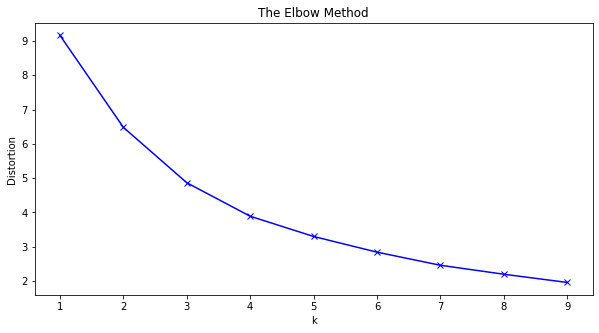

In [45]:
plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method')
plt.show()

### 10.2 Seems the best K is around 5

### 10.3 Perform K-Means clustering

In [46]:
kclusters = 5

kmeans = KMeans(n_clusters=kclusters, init='k-means++', max_iter=15, random_state=8).fit(k_test)

kmeans.labels_[0:10] 

array([2, 2, 3, 3, 3, 3, 1, 3, 3, 0], dtype=int32)

### 10.4 Add cluster label for stations

In [47]:
nearby_venues_select_grouped.insert(0, 'Cluster Labels', kmeans.labels_)
nearby_venues_select_grouped = pd.merge(df_Z1_topborpax, nearby_venues_select_grouped, on='Station')
nearby_venues_select_grouped.head()

,Station,Local authority,Managed by,PAX mn,Latitude,Longitude,Zone,Postcode,Cluster Labels,Art Gallery,Art Museum,History Museum,Japanese Restaurant,Opera House,Park,Theater,Museum,Art/Museum,Performance,Total,Score
0,Aldgate,City of London,London Underground,8.846940,51.514342,-0.075627,1,EC3N 1AH,2,2,0,0,2,0,0,0,0,2,0,4,0.012308
1,Aldgate East,Tower Hamlets,London Underground,13.998292,51.515082,-0.073001,1,E1 7PT,2,2,0,0,2,0,0,0,0,2,0,4,0.012308
2,Baker Street,Westminster,London Underground,28.784591,51.523130,-0.156904,1,NW1 5LA,3,1,0,1,1,0,1,1,1,2,1,5,0.015385
3,Bank,City of London,London Underground,61.796153,51.513347,-0.089000,1,EC3V 3LA,3,2,0,2,0,0,2,2,2,4,2,8,0.024615
4,Barbican,City of London,London Underground,11.827212,51.520215,-0.097722,1,EC1A 4JA,3,2,0,1,0,0,1,1,1,3,1,5,0.015385


### 10.5 Furthermore, I hope to identify stations with at least one venue for each of the food, park, art/museum and performance category, and will remove stations that lack any

In [48]:
stations_select = nearby_venues_select_grouped.loc[(nearby_venues_select_grouped[['Japanese Restaurant', 'Park', 'Art/Museum', 'Performance']] != 0). all(axis=1)]
stations_select.sort_values(['Score'], ascending=False).reset_index(drop=True)

,Station,Local authority,Managed by,PAX mn,Latitude,Longitude,Zone,Postcode,Cluster Labels,Art Gallery,Art Museum,History Museum,Japanese Restaurant,Opera House,Park,Theater,Museum,Art/Museum,Performance,Total,Score
0,Temple,Westminster,London Underground,8.946533,51.511041,-0.113726,1,WC2R 2PH,0,2,0,2,2,1,3,8,2,4,9,18,0.055385
1,Russell Square,Camden,London Underground,11.449159,51.523013,-0.124590,1,WC1N 1LG,3,1,0,4,3,0,5,2,4,5,2,15,0.046154
2,Holborn,Camden,London Underground,32.538456,51.517236,-0.119841,1,WC2B 6AA,0,1,0,2,2,1,1,5,2,3,6,12,0.036923
3,Tottenham Court Road,Westminster,London Underground,41.334148,51.516211,-0.131110,1,W1D 2DA,0,1,0,1,1,0,1,5,1,2,5,9,0.027692
4,Westminster,Westminster,London Underground,25.595405,51.501402,-0.125002,1,SW1A 2JR,1,2,2,0,1,0,3,1,2,4,1,9,0.027692
5,Goodge Street,Camden,London Underground,7.524287,51.520613,-0.134808,1,W1T 2HF,3,1,0,1,1,0,1,2,1,2,2,6,0.018462
6,Baker Street,Westminster,London Underground,28.784591,51.523130,-0.156904,1,NW1 5LA,3,1,0,1,1,0,1,1,1,2,1,5,0.015385
7,Edgware Road (Cir),Westminster,London Underground,7.148956,51.519998,-0.167668,1,NW1 5DH,2,1,0,0,2,0,1,1,0,1,1,5,0.015385
8,High Street Kensington,Kensington & Chelsea,London Underground,12.762568,51.500729,-0.191566,1,W8 5SA,3,1,0,1,1,1,1,0,1,2,1,5,0.015385
9,Great Portland Street,Westminster,London Underground,8.081276,51.523789,-0.143961,1,W1W 5PP,1,1,0,0,1,0,1,1,0,1,1,4,0.012308


### 10.6 As shown above, there are 11 stations that statisfy the requirements, in clusters 0, 1, 2 and 3.

### Checking into cluster 4 since not any station in cluster 4 is shown in the table.

In [49]:
df_c4 = nearby_venues_select_grouped[nearby_venues_select_grouped['Cluster Labels']==4]
df_c4

,Station,Local authority,Managed by,PAX mn,Latitude,Longitude,Zone,Postcode,Cluster Labels,Art Gallery,Art Museum,History Museum,Japanese Restaurant,Opera House,Park,Theater,Museum,Art/Museum,Performance,Total,Score
36,Pimlico,Westminster,London Underground,10.971039,51.489553,-0.133108,1,SW1V 2JA,4,0,1,0,0,0,6,2,1,1,2,9,0.027692
37,Queensway,Westminster,London Underground,8.523970,51.510449,-0.187420,1,W2 4SS,4,0,0,0,0,0,1,0,0,0,0,1,0.003077
47,Warren Street,Camden,London Underground,20.110864,51.524580,-0.138278,1,NW1 3AA,4,0,0,0,1,0,2,1,0,0,1,4,0.012308


### 10.7 Before going to into each cluster, will show the clustering results on map for better visualisation

In [50]:
map_clusters = folium.Map(location = [latitude, longitude], zoom_start=13)

x = np.arange(kclusters)
ys = [i + x + (i*x)**100 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(stations_select['Latitude'], stations_select['Longitude'], stations_select['Station'], stations_select['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=1.2).add_to(map_clusters)
       
map_clusters

### 10.8 Next, to look into the characteristics of each cluster via summary tables and charts

In [51]:
stations_select.loc[stations_select['Cluster Labels'] == 0].sort_values(['Score'], ascending=False)

,Station,Local authority,Managed by,PAX mn,Latitude,Longitude,Zone,Postcode,Cluster Labels,Art Gallery,Art Museum,History Museum,Japanese Restaurant,Opera House,Park,Theater,Museum,Art/Museum,Performance,Total,Score
43,Temple,Westminster,London Underground,8.946533,51.511041,-0.113726,1,WC2R 2PH,0,2,0,2,2,1,3,8,2,4,9,18,0.055385
21,Holborn,Camden,London Underground,32.538456,51.517236,-0.119841,1,WC2B 6AA,0,1,0,2,2,1,1,5,2,3,6,12,0.036923
44,Tottenham Court Road,Westminster,London Underground,41.334148,51.516211,-0.131110,1,W1D 2DA,0,1,0,1,1,0,1,5,1,2,5,9,0.027692


In [52]:
stations_select.loc[stations_select['Cluster Labels'] == 1].sort_values(['Score'], ascending=False)

,Station,Local authority,Managed by,PAX mn,Latitude,Longitude,Zone,Postcode,Cluster Labels,Art Gallery,Art Museum,History Museum,Japanese Restaurant,Opera House,Park,Theater,Museum,Art/Museum,Performance,Total,Score
48,Westminster,Westminster,London Underground,25.595405,51.501402,-0.125002,1,SW1A 2JR,1,2,2,0,1,0,3,1,2,4,1,9,0.027692
18,Great Portland Street,Westminster,London Underground,8.081276,51.523789,-0.143961,1,W1W 5PP,1,1,0,0,1,0,1,1,0,1,1,4,0.012308


In [53]:
stations_select.loc[stations_select['Cluster Labels'] == 2].sort_values(['Score'], ascending=False)

,Station,Local authority,Managed by,PAX mn,Latitude,Longitude,Zone,Postcode,Cluster Labels,Art Gallery,Art Museum,History Museum,Japanese Restaurant,Opera House,Park,Theater,Museum,Art/Museum,Performance,Total,Score
12,Edgware Road (Cir),Westminster,London Underground,7.148956,51.519998,-0.167668,1,NW1 5DH,2,1,0,0,2,0,1,1,0,1,1,5,0.015385


In [54]:
stations_select.loc[stations_select['Cluster Labels'] == 3].sort_values(['Score'], ascending=False)

,Station,Local authority,Managed by,PAX mn,Latitude,Longitude,Zone,Postcode,Cluster Labels,Art Gallery,Art Museum,History Museum,Japanese Restaurant,Opera House,Park,Theater,Museum,Art/Museum,Performance,Total,Score
38,Russell Square,Camden,London Underground,11.449159,51.523013,-0.124590,1,WC1N 1LG,3,1,0,4,3,0,5,2,4,5,2,15,0.046154
17,Goodge Street,Camden,London Underground,7.524287,51.520613,-0.134808,1,W1T 2HF,3,1,0,1,1,0,1,2,1,2,2,6,0.018462
2,Baker Street,Westminster,London Underground,28.784591,51.523130,-0.156904,1,NW1 5LA,3,1,0,1,1,0,1,1,1,2,1,5,0.015385
20,High Street Kensington,Kensington & Chelsea,London Underground,12.762568,51.500729,-0.191566,1,W8 5SA,3,1,0,1,1,1,1,0,1,2,1,5,0.015385


In [55]:
stations_select.groupby('Cluster Labels').mean()

,PAX mn,Latitude,Longitude,Art Gallery,Art Museum,History Museum,Japanese Restaurant,Opera House,Park,Theater,Museum,Art/Museum,Performance,Total,Score
Cluster Labels,,,,,,,,,,,,,,,
0,27.606379,51.514829,-0.121559,1.333333,0.0,1.666667,1.666667,0.666667,1.666667,6.00,1.666667,3.00,6.666667,13.00,0.040000
1,16.838341,51.512595,-0.134482,1.500000,1.0,0.000000,1.000000,0.000000,2.000000,1.00,1.000000,2.50,1.000000,6.50,0.020000
2,7.148956,51.519998,-0.167668,1.000000,0.0,0.000000,2.000000,0.000000,1.000000,1.00,0.000000,1.00,1.000000,5.00,0.015385
3,15.130151,51.516871,-0.151967,1.000000,0.0,1.750000,1.500000,0.250000,2.000000,1.25,1.750000,2.75,1.500000,7.75,0.023846


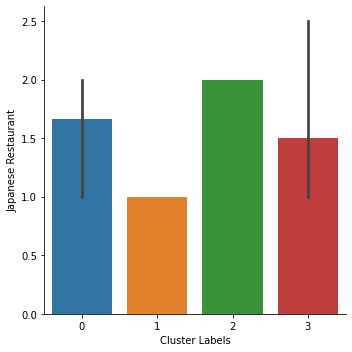

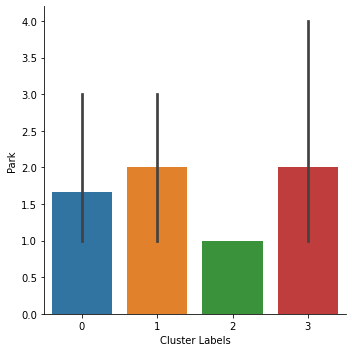

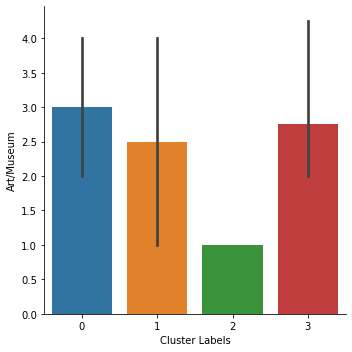

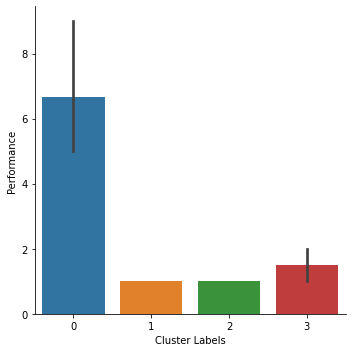

In [56]:
sns.catplot(x='Cluster Labels', y='Japanese Restaurant', data=stations_select, kind='bar')
sns.catplot(x='Cluster Labels', y='Park', data=stations_select, kind='bar')
sns.catplot(x='Cluster Labels', y='Art/Museum', data=stations_select, kind='bar')
sns.catplot(x='Cluster Labels', y='Performance', data=stations_select, kind='bar')

### Venues around the top 5 stations are listed out.

In [57]:
station_top = ['Temple', 'Russell Square', 'Holborn', 'Tottenham Court Road', 'Westminster']
venues_select = nearby_venues_select[nearby_venues_select['Station'].isin(station_top)].reset_index(drop=True)
venues_select

,Station,Station Latitude,Station Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,Holborn,51.517236,-0.119841,Sir John Soane's Museum,4ac518d3f964a5204fa720e3,51.516833,-0.117540,165,History Museum
1,Holborn,51.517236,-0.119841,Lincoln's Inn Fields,4ad862b4f964a520291121e3,51.516114,-0.116558,259,Park
2,Holborn,51.517236,-0.119841,Gillian Lynne Theatre,4ac518e9f964a520ccab20e3,51.515231,-0.122492,289,Theater
3,Holborn,51.517236,-0.119841,Royal Opera House,4ac518e8f964a5207fab20e3,51.513083,-0.121968,485,Opera House
4,Holborn,51.517236,-0.119841,British Museum,4ac518d2f964a5203da720e3,51.519009,-0.126437,497,History Museum
5,Holborn,51.517236,-0.119841,Shaftesbury Theatre,4ac518e7f964a5205cab20e3,51.516065,-0.125886,438,Theater
6,Holborn,51.517236,-0.119841,eat TOKYO,505a370de4b034c534cd8d67,51.519849,-0.117410,336,Japanese Restaurant
7,Holborn,51.517236,-0.119841,Roka,545505a2498e550f5aefc0af,51.513312,-0.116194,504,Japanese Restaurant
8,Holborn,51.517236,-0.119841,Lyceum Theatre,4bad083df964a52078263be3,51.511598,-0.119785,627,Theater
9,Holborn,51.517236,-0.119841,180 The Strand,52fe72e0498e6484322373d8,51.512671,-0.115009,608,Art Gallery


## Results

### C_3 has the most stations (4 stations), while C_0 has the most number of venues around each station on average (13 venues). 
### In terms of each venue category, C_2, C_1/3, C_0, C_0 outperform in the Japanese Restaurant, Park, Art/Museum, Theater category respectively.
### C_1 and C_2 are not that bad in terms of food and green spaces, but they lag in Art/Museum and Theater.
### C_3 is similar to C_0 in regards to Food, Park and Art/Museum, but weaker in Theater.
### As a whole, C_0 appears to be the better choice, with balanced ranking in all categories. In addition, as seen from the map, the stations in C_0 (in red circle) are close to each other, and thus flexible to pass from one to the other.

### Show venues around the top 5 stations on map

In [58]:
venues_select_museum = venues_select[(venues_select['Venue Category'] == 'History Museum') | (venues_select['Venue Category'] =='Art Museum')]
venues_select_museum.drop_duplicates(subset ="Venue", keep = 'first', inplace = True)
venues_select_museum.reset_index(drop=True)

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,Station,Station Latitude,Station Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,Holborn,51.517236,-0.119841,Sir John Soane's Museum,4ac518d3f964a5204fa720e3,51.516833,-0.117540,165,History Museum
1,Holborn,51.517236,-0.119841,British Museum,4ac518d2f964a5203da720e3,51.519009,-0.126437,497,History Museum
2,Russell Square,51.523013,-0.124590,Charles Dickens Museum,4be69ded2468c92835880143,51.523523,-0.116409,569,History Museum
3,Russell Square,51.523013,-0.124590,The Postal Museum,4dcc1a2afa76d745f064241e,51.524853,-0.113885,769,History Museum
4,Temple,51.511041,-0.113726,Two Temple Place,4ee1d846a17c79c0e9344b09,51.511523,-0.112236,116,History Museum
5,Westminster,51.501402,-0.125002,National Gallery,4ac518cdf964a520e6a520e3,51.508876,-0.128478,866,Art Museum
6,Westminster,51.501402,-0.125002,Sainsbury Wing National Gallery,5320a0a6498e8dd49f5aa981,51.508384,-0.129001,825,Art Museum


In [59]:
venues_select_art = venues_select[venues_select['Venue Category'] == 'Art Gallery']
venues_select_art.drop_duplicates(subset ="Venue", keep = 'first', inplace = True)
venues_select_art.reset_index(drop=True)

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,Station,Station Latitude,Station Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,Holborn,51.517236,-0.119841,180 The Strand,52fe72e0498e6484322373d8,51.512671,-0.115009,608,Art Gallery
1,Russell Square,51.523013,-0.124590,Crypt Gallery,4c9269f87088a1433141b943,51.527110,-0.129690,576,Art Gallery
2,Temple,51.511041,-0.113726,Hayward Gallery,4ac518d2f964a5203ba720e3,51.506136,-0.115709,563,Art Gallery
3,Tottenham Court Road,51.516211,-0.131110,The Photographers' Gallery,4ac518cef964a52009a620e3,51.515070,-0.138969,559,Art Gallery
4,Westminster,51.501402,-0.125002,Institute of Contemporary Arts (ICA),4ac518b9f964a520b6a120e3,51.506265,-0.130817,674,Art Gallery


In [60]:
venues_select_park = venues_select[venues_select['Venue Category'] == 'Park'].reset_index(drop=True)
venues_select_park.drop_duplicates(subset ="Venue", keep = 'first', inplace = True)
venues_select_park.reset_index(drop=True)

,Station,Station Latitude,Station Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,Holborn,51.517236,-0.119841,Lincoln's Inn Fields,4ad862b4f964a520291121e3,51.516114,-0.116558,259,Park
1,Russell Square,51.523013,-0.124590,Tavistock Square,4ac518d1f964a520d0a620e3,51.525006,-0.129068,381,Park
2,Russell Square,51.523013,-0.124590,Gordon Square,4ada5af6f964a520c22121e3,51.524098,-0.130763,444,Park
3,Russell Square,51.523013,-0.124590,Brunswick Square Gardens,4c28812a97d00f479ee13fea,51.524177,-0.122322,203,Park
4,Russell Square,51.523013,-0.124590,Bloomsbury Square,4ac518d3f964a52082a720e3,51.518740,-0.122622,494,Park
5,Russell Square,51.523013,-0.124590,Coram's Fields,4bca013ecc8cd13afcabbccf,51.523979,-0.119736,352,Park
6,Temple,51.511041,-0.113726,Temple Gardens,4ac518d1f964a520d1a620e3,51.511154,-0.111472,156,Park
7,Temple,51.511041,-0.113726,Bernie Spain Gardens,4c21fbbc11de20a13c1084ce,51.507717,-0.109118,488,Park
8,Tottenham Court Road,51.516211,-0.131110,Soho Square,4ac518cff964a5206ba620e3,51.515286,-0.132209,128,Park
9,Westminster,51.501402,-0.125002,Victoria Tower Gardens,4b9f9704f964a5205d2d37e3,51.496729,-0.125016,520,Park


In [61]:
venues_select_food = venues_select[venues_select['Venue Category'] == 'Japanese Restaurant'].reset_index(drop=True)
venues_select_food.drop_duplicates(subset ="Venue", keep = 'first', inplace = True)
venues_select_food.reset_index(drop=True)

,Station,Station Latitude,Station Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,Holborn,51.517236,-0.119841,eat TOKYO,505a370de4b034c534cd8d67,51.519849,-0.117410,336,Japanese Restaurant
1,Holborn,51.517236,-0.119841,Roka,545505a2498e550f5aefc0af,51.513312,-0.116194,504,Japanese Restaurant
2,Russell Square,51.523013,-0.124590,Hare & Tortoise,4b411423f964a520aac025e3,51.524086,-0.123015,161,Japanese Restaurant
3,Westminster,51.501402,-0.125002,Okan,5a99bc4f95a7222a9d15d51e,51.502040,-0.118192,477,Japanese Restaurant


In [62]:
venues_select_theater = venues_select[(venues_select['Venue Category'] == 'Theater') | (venues_select['Venue Category'] =='Opera House')]
venues_select_theater.drop_duplicates(subset ="Venue", keep = 'first', inplace = True)
venues_select_theater.reset_index(drop=True)

/opt/conda/envs/Python-3.7-OpenCE/lib/python3.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,Station,Station Latitude,Station Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,Holborn,51.517236,-0.119841,Gillian Lynne Theatre,4ac518e9f964a520ccab20e3,51.515231,-0.122492,289,Theater
1,Holborn,51.517236,-0.119841,Royal Opera House,4ac518e8f964a5207fab20e3,51.513083,-0.121968,485,Opera House
2,Holborn,51.517236,-0.119841,Shaftesbury Theatre,4ac518e7f964a5205cab20e3,51.516065,-0.125886,438,Theater
3,Holborn,51.517236,-0.119841,Lyceum Theatre,4bad083df964a52078263be3,51.511598,-0.119785,627,Theater
4,Holborn,51.517236,-0.119841,Dominion Theatre,4ac518e7f964a52044ab20e3,51.516932,-0.129649,680,Theater
5,Holborn,51.517236,-0.119841,Duchess Theatre,4ac518e7f964a52047ab20e3,51.512239,-0.119460,556,Theater
6,Temple,51.511041,-0.113726,National Theatre,4ac7a2caf964a520adb820e3,51.507376,-0.114793,414,Theater
7,Temple,51.511041,-0.113726,Olivier Theatre,5022b0c1e4b0464790dcff76,51.507414,-0.114397,406,Theater
8,Temple,51.511041,-0.113726,Dorfman Theatre,542eec4e498ee31baa076ef7,51.507167,-0.113350,432,Theater
9,Temple,51.511041,-0.113726,Lyttelton Theatre,4b7fe34ef964a5209c4230e3,51.507249,-0.114926,430,Theater


In [63]:
# color codes: https://matplotlib.org/stable/tutorials/colors/colors.html

map_venue = folium.Map(location = [latitude, longitude], zoom_start = 15)

for lat, lng, station, borough in zip(df_Z1_topborpax['Latitude'], 
                                  df_Z1_topborpax['Longitude'],
                                  df_Z1_topborpax['Station'],
                                  df_Z1_topborpax['Local authority']):
    label = '{}, {}'.format(station, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=7,
        popup=label,
        color='orangered',
        fill=True,
        fill_color='#0343df',
        fill_opacity=0.8).add_to(map_venue)  

for lat, lng, venue, category in zip(venues_select_theater['Venue Latitude'], 
                                  venues_select_theater['Venue Longitude'],
                                  venues_select_theater['Venue'],
                                  venues_select_theater['Venue Category']):
    label = '{}, {}'.format(venue, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6.5,
        popup=label,
        color='azure', # gold
        fill=True,
        fill_color='#ffd700',
        fill_opacity=0.8).add_to(map_venue)

for lat, lng, venue, category in zip(venues_select_park['Venue Latitude'], 
                                  venues_select_park['Venue Longitude'],
                                  venues_select_park['Venue'],
                                  venues_select_park['Venue Category']):
    label = '{}, {}'.format(venue, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6.5,
        popup=label,
        color='azure', # lime
        fill=True,
        fill_color='#00ff00',
        fill_opacity=0.8).add_to(map_venue)

for lat, lng, venue, category in zip(venues_select_art['Venue Latitude'], 
                                  venues_select_art['Venue Longitude'],
                                  venues_select_art['Venue'],
                                  venues_select_art['Venue Category']):
    label = '{}, {}'.format(venue, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6.5,
        popup=label,
        color='azure', # lavender
        fill=True,
        fill_color='#c79fef',
        fill_opacity=0.8).add_to(map_venue)
    
for lat, lng, venue, category in zip(venues_select_museum['Venue Latitude'], 
                                  venues_select_museum['Venue Longitude'],
                                  venues_select_museum['Venue'],
                                  venues_select_museum['Venue Category']):
    label = '{}, {}'.format(venue, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6.5,
        popup=label,
        color='azure', # tomato
        fill=True,
        fill_color='#ef4026',
        fill_opacity=0.8).add_to(map_venue)

for lat, lng, venue, category in zip(venues_select_food['Venue Latitude'], 
                                  venues_select_food['Venue Longitude'],
                                  venues_select_food['Venue'],
                                  venues_select_food['Venue Category']):
    label = '{}, {}'.format(venue, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6.5,
        popup=label,
        color='azure', # cyan
        fill=True,
        fill_color='#00ffff',
        fill_opacity=0.8).add_to(map_venue)
    
display(map_venue)

### Future enhancement: to add attributes of popularity of venues from Foursquare

In [67]:
def getVenueDetails(venue_ids):
    
    venues_list=[]
    
    for venue_id in (venue_ids):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        
            
        # make the GET request
        results = requests.get(url).json()["response"]
        print(results)
        # venue_data=results
        
        # return only relevant information for each nearby venue
        try:
            
            venue_likes=results['venue']['likes']['count']
            # venue_likes=venue_data['venue']['likes']['count']
           
            venue_rating=results['venue']['rating']
            # venue_rating=venue_data['venue']['rating']
                
            venues_list.append([venue_id,venue_likes,venue_rating])
            # venues_list.append([venue_id,(['venue']['likes']['count']),(['venue']['rating'])])
        except KeyError:
            pass

    # venue_details = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    # venue_details.columns = ['Venue ID', 'Venue Likes', 'Venue Rating'] # 
    
    # return(venue_details)
    return(venues_list)
      

In [ ]:
venues_interest_details = getVenueDetails(venue_ids=nearby_venues_select['Venue ID'])

In [71]:
venues_interest_details

[['4c65392694160f47e7bf2e17', 29, 8.0],
 ['4bb1c12ff964a520a7a13ce3', 435, 8.1],
 ['4b900120f964a5208e6f33e3', 30, 8.1],
 ['51324f0fe4b08f70f1c4a367', 105, 7.9],
 ['4bb1c12ff964a520a7a13ce3', 435, 8.1],
 ['4b900120f964a5208e6f33e3', 30, 8.1],
 ['51324f0fe4b08f70f1c4a367', 105, 7.9],
 ['4c65392694160f47e7bf2e17', 29, 8.0],
 ['4ac518d3f964a52054a720e3', 882, 7.8],
 ['4c2e486b66e40f471af0bf8b', 144, 9.2],
 ['4ac518d3f964a52071a720e3', 420, 9.0],
 ['4b868071f964a520e38c31e3', 247, 8.3],
 ['4b233922f964a520785424e3', 3458, 9.7],
 ['4ac518d3f964a5205aa720e3', 63, 8.0],
 ['4d53c406a64560fce0f3b23a', 31, 7.7],
 ['4ad3be62f964a52012e620e3', 88, 8.7],
 ['4ac518d2f964a5203ca720e3', 1056, 8.7],
 ['4c1cd32bb306c928426b64b7', 105, 9.1],
 ['4ad64197f964a5201d0621e3', 1786, 9.2],
 ['4ac518e7f964a52040ab20e3', 201, 8.7],
 ['4d8f77893bfef04d3225af86', 122, 7.9],
 ['4c1cd32bb306c928426b64b7', 105, 9.1],
 ['4ac518d2f964a5203ca720e3', 1056, 8.7],
 ['4ac518e7f964a52040ab20e3', 201, 8.7],
 ['4ad3be62f964a520

In [81]:
venues_details = pd.DataFrame(Venues_interest_details)
venues_details.columns = ['Venue ID', 'Venue Likes', 'Venue Rating']
venues_details

,Venue ID,Venue Likes,Venue Rating
0,4c65392694160f47e7bf2e17,29,8.0
1,4bb1c12ff964a520a7a13ce3,435,8.1
2,4b900120f964a5208e6f33e3,30,8.1
3,51324f0fe4b08f70f1c4a367,105,7.9
4,4bb1c12ff964a520a7a13ce3,435,8.1
5,4b900120f964a5208e6f33e3,30,8.1
6,51324f0fe4b08f70f1c4a367,105,7.9
7,4c65392694160f47e7bf2e17,29,8.0
8,4ac518d3f964a52054a720e3,882,7.8
9,4c2e486b66e40f471af0bf8b,144,9.2


In [84]:
venues_select_details = pd.merge(venues_select, venues_details, on='Venue ID')
venues_select_details.drop_duplicates(subset ="Venue ID", keep = 'first', inplace = True)
venues_select_details

,Station,Station Latitude,Station Longitude,Venue,Venue ID,Venue Latitude,Venue Longitude,Venue Distance,Venue Category,Venue Likes,Venue Rating
0,Holborn,51.517236,-0.119841,180 The Strand,52fe72e0498e6484322373d8,51.512671,-0.115009,608,Art Gallery,86,8.6
2,Temple,51.511041,-0.113726,Two Temple Place,4ee1d846a17c79c0e9344b09,51.511523,-0.112236,116,History Museum,47,8.7
3,Temple,51.511041,-0.113726,Temple Gardens,4ac518d1f964a520d1a620e3,51.511154,-0.111472,156,Park,62,8.5
4,Temple,51.511041,-0.113726,National Theatre,4ac7a2caf964a520adb820e3,51.507376,-0.114793,414,Theater,792,9.4
6,Temple,51.511041,-0.113726,Dorfman Theatre,542eec4e498ee31baa076ef7,51.507167,-0.113350,432,Theater,38,9.1
7,Temple,51.511041,-0.113726,Bernie Spain Gardens,4c21fbbc11de20a13c1084ce,51.507717,-0.109118,488,Park,40,8.0
